# 所用包

In [1]:
# deap-遗传系统工具箱，更快的可以用geatpy
from deap import base        #
from deap import creator     #元工厂，通过添加新属性来扩展现有类
from deap import tools       #函数的容器，通过别名机制和自定义现有函数来创建性的运算符
import random
import matplotlib.pyplot as plt

# OneMax问题（查找给定长度的二进制串，最大化该二进制串中的总和）

## 常量

In [2]:
ONE_MAX_LENGTH = 100        # lenth of bit string to be optimized 生成的对象的数目
POPULATI_SIZE = 200         # number of individuals in population
P_CROSSOVER = 0.9           # probability for crossover 交叉概率
P_MUTATION = 0.1            # probability for mutating and individual
MAX_GENEERATION = 50        # max number of generation for stoping consition

## 创建物种

In [3]:
toolbox = base.Toolbox()                                              #定义toolbox变量
toolbox.register("ZeroOrOne",random.randint,0,1)                      #ZeroOrOne操作，自定义random.randomint(a,b)函数，调用时随机返回0或1

creator.create("FitnessMax",base.Fitness,weights=(1.0,))              #Fitness类，FitnessMax策略
creator.create("Individual",list,fitness=creator.FitnessMax)          #Individual类表示种群每个个体，并增加Fitness属性

#创建IndividualCreater运算符，将100个随机生成 的0或1填充到单个实例
#creator.Individual为放置结果对象的容器类别，ZeroOrOne操作是生成对象的函数
toolbox.register("IndividualCreater",tools.initRepeat,creator.Individual,toolbox.ZeroOrOne,ONE_MAX_LENGTH)

## 计算适应度

In [4]:
#注册用于创建个体列表的populationCreator操作，定义InitRepeat基类操作
#列表类为容器类型，personalCreator运算符为用于生成列表中对象的函数
#没有最后一项生成对象数目意味着使用时要指定此参数
toolbox.register("populationCreator",tools.initRepeat,list,toolbox.IndividualCreater)

#定义函数计算个体中1的数量，再deap中是适用度函数为元组，因此，返回单个值时，需要用逗号将其声明为元组
def oneMaxFitness(Individual):
    return sum(Individual),
toolbox.register("evaluate",oneMaxFitness)                            #用evaluate运算符定义适用度函数-deap中的约定

## 创建遗传算子

In [5]:
#选择算子包括：selRoulette()-轮盘选择；selStochasticUniversalSampling()-随机遍历选择；selTournament()-锦标赛选择
toolbox.register("select",tools.selTournament,tournsize=3)             #选择算子-锦标赛选择,tournsize为3

#交叉算子包括：cxOnePoing()-单点交叉；cxUniform()-均匀交叉；cxOrdered()-有序交叉；cxPartialyMatched()-实现部分匹配交叉
toolbox.register("mate",tools.cxOnePoint)                             #交叉算子-单点交叉

#突变算子包括：mutFlipbit()-位翻转突变；mutGaussian()正态分布突变
toolbox.register("mutate",tools.mutFlipBit,indpb=1.0/ONE_MAX_LENGTH)  #突变算子-位翻转突变

## 遗传算法进化流程

### 初始化数据

In [6]:
#创建初始种群，初始化generationCounter变量，用于判断代际数
population = toolbox.populationCreator(n=POPULATI_SIZE)
generationCountor = 0

#用map()函数将evaluate操作应用于种群的每个个体来计算适应度，得到结果转为元组
fitnessValues = list(map(toolbox.evaluate,population))

#用zip()函数将适应度的每个项与个体列表中的项来匹配
for individual,fitnessValues in zip(population,fitnessValues):
    individual.fitness.values = fitnessValues

#从每个个体的适应度中提取第一个值以获取统计数据
fitnessValues = [individual.fitness.values[0] for individual in population]

#创建两个列表用于储存统计值
maxFitnessValues = []
meanFitnessValues = []

### 开始进化

In [8]:
while max(fitnessValues)<ONE_MAX_LENGTH and generationCountor<MAX_GENEERATION:
    generationCountor += 1
    offspring = toolbox.select(population,len(population))           #选择运算，用toolbox.select定义竞标赛选择，将物种与长度传递下去
    offspring = list(map(toolbox.clone,offspring))                   #将选择的个体克隆下来，不影响原始种群
    
    #将被选择的个体用crossover运算符将他们配对创建实际后代
    #offspring列表中的每个偶数索引项与奇数索引项对作为双亲，P-CROSSOVER常数为交叉概率，并伤处后代适应度值
    for child1,child2 in zip(offspring[1::2],offspring[1::2]):
        if random.random() < P_CROSSOVER:
            toolbox.mate(child1,child2)
            del child1.fitness.values
            del child2.fitness.values
    
    #突变运算，反转位操作，突变概率由P-MUTATION设置，如果突变则删除其适应度值
    for mutant in offspring:
        if random.random() < P_MUTATION:
            toolbox.mutate(mutant)
            del mutant.fitness.values
            
    #用Fitness类的valid属性找出经过交叉或者突变删除了适应度的新个体，然后通过与原始种群适应度相同的计算方式计算出新适应度
    freshIndividuals = [ind for ind in offspring if not ind.fitness.values]
    freshFitnessValues = list (map(toolbox.evaluate,freshIndividuals))
    for individual,fitnessValue in zip(freshIndividuals,freshFitnessValues):
        individual.fitness.values = fitnessValue
    
    population[:] = offspring                                       #更新种群
    fitnessValues = [ind.fitness.values[0] for ind in population]   #更新适应度值
    
    #更新统计值
    maxFitness = max(fitnessValues)                                 #最大适应度
    meanFitness = sum(fitnessValues)/len(population)                #平均适应度
    maxFitnessValues.append(maxFitness)
    meanFitnessValues.append(meanFitness)
    print("- Generation{}: Max Fitness = {}, Avg Fitness = {}".format(generationCountor,maxFitness,meanFitness))
    best_index = fitnessValues.index(max(fitnessValues))            #用最大适应度找到最佳个体
    print("Best Individual = ",*population[best_index],"\n")

- Generation2: Max Fitness = 63.0, Avg Fitness = 53.805
Best Individual =  0 0 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 

- Generation3: Max Fitness = 63.0, Avg Fitness = 57.28
Best Individual =  0 0 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 

- Generation4: Max Fitness = 66.0, Avg Fitness = 59.695
Best Individual =  1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 0 1 0 

- Generation5: Max Fitness = 66.0, Avg Fitness = 61.655
Best Individual =  1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1

- Generation47: Max Fitness = 81.0, Avg Fitness = 79.335
Best Individual =  1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 

- Generation48: Max Fitness = 80.0, Avg Fitness = 79.825
Best Individual =  1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 

- Generation49: Max Fitness = 82.0, Avg Fitness = 80.0
Best Individual =  1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 

- Generation50: Max Fitness = 82.0, Avg Fitness = 80.025
Best Individual =  1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 0 1 1 

### 结果展示

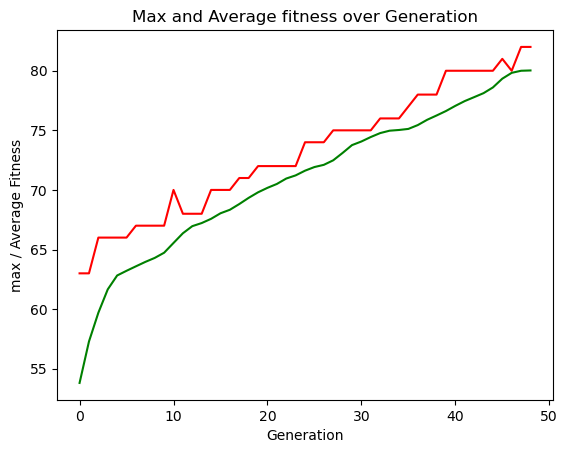

In [9]:
plt.plot(maxFitnessValues,color='red')
plt.plot(meanFitnessValues,color='green')
plt.xlabel('Generation')
plt.ylabel('max / Average Fitness')
plt.title('Max and Average fitness over Generation')
plt.show()